Practica 1 FAA
======


#### Lucía Asencio y Alfonso Carvajal
#### Grupo 1461, pareja 16


## Particionado
----------------

Para esta entrega hemos implementado dos estrategias de particionado, 
* Valicación __simple,__ y
* Validación __cruzada__


### Validación simple

En el primer caso, el usuario escoge qué porcentaje de los datos va a ser usado para probar el modelo (el conjunto de test) y los datos restantes serán usados para entrenar el modelo. Esta validación conlleva por tanto una única partición de los datos.

Para una consulta rápida, adjuntamos el código que crea las particiones en validación simple.

``` python
    #Crea particiones segun el metodo tradicional de division de los datos segun el porcentaje deseado.
    # Devuelve una lista de particiones (clase Particion)
    def creaParticiones(self,datos,seed=None):
        # we assign a new value to seed only if it is None already
        if seed == None:
            random.seed(seed)

        # number of rows of the datos Matrix (number of inidvidual data)
        totalRows = len(datos)
        # Assuming porcentajeDeseado refers to the percentage of the data we want to save for testing
        # we obtain the number of rows (data) to use for testing
        testRows = int( (self.porcentajeDeseado * totalRows)/100 )
        rows = list(range(0, totalRows))
        random.shuffle(rows)
        particionSimple = Particion()
        # array size of totalRows - testRows
        particionSimple.indicesTrain = rows[testRows :]
        # array size of testRows
        particionSimple.indicesTest = rows[: testRows]

        self.listaParticiones.append(particionSimple)


        return self.listaParticiones```


#### Lenses
Comencemos viendo cómo la validación simple particiona los datos de las lentillas proporcionados para la práctica. A través del parámetro `porcentaje`, configuramos el porcentaje de datos que van destinados al conjunto de prueba. Consultamos en el objeto estrategia el número y estructura de la/s particiones creadas.

In [2]:


from plantillasArquitectura import Datos as d
from plantillasArquitectura import EstrategiaParticionado as ep

porcentaje = 25
dataset = d.Datos('./plantillasArquitectura/datos/conjunto_datos_lentillas.txt')
estrategia = ep.ValidacionSimple(porcentaje)
listaParticiones = estrategia.creaParticiones(dataset.datos)

print('Tal y como esperamos, la lista de particiones de la estrategia tiene longitud ', len(listaParticiones))
print('\nHay ', len(listaParticiones[0].indicesTrain), 'índices (más o menos el ',100-porcentaje,'% de ',len(dataset.datos),', que es el número de datos) destinados al entrenamiento del modelo, y son:')
print(listaParticiones[0].indicesTrain)
print('\nLos ',len(listaParticiones[0].indicesTest),' índices restantes forman el conjunto de test: ')
print(listaParticiones[0].indicesTest)

Tal y como esperamos, la lista de particiones de la estrategia tiene longitud  1

Hay  18 índices (más o menos el  75 % de  24 , que es el número de datos) destinados al entrenamiento del modelo, y son:
[6, 12, 21, 18, 17, 1, 10, 4, 19, 7, 11, 14, 13, 3, 5, 20, 9, 15]

Los  6  índices restantes forman el conjunto de test: 
[8, 0, 23, 16, 22, 2]


#### Tic-tac-toe
Como en este fichero hay mayor número de datos, imprimiremos simplemente el número de particiones (que, al ser validación simple, esperamos que sea uno), y el número de elementos de cada conjunto de la partición, para comprobar que se obtiene el porcentaje deseado.

In [3]:
porcentaje = 30
dataset = d.Datos('./plantillasArquitectura/datos/tic-tac-toe.data')
estrategia = ep.ValidacionSimple(porcentaje)
listaParticiones = estrategia.creaParticiones(dataset.datos)

print('El fichero tic-tac-toe cuenta con un total de ', len(dataset.datos),' datos')
print('La lista de particiones de la estrategia tiene longitud', len(listaParticiones))
print('\nHay ', len(listaParticiones[0].indicesTrain), 'índices  en el conjunto de train, acorde con el ',100-porcentaje,'% esperado.')
print('Los ',len(listaParticiones[0].indicesTest),'índices restantes forman el conjunto de test, un',porcentaje ,'% de los datos totales')


El fichero tic-tac-toe cuenta con un total de  958  datos
La lista de particiones de la estrategia tiene longitud 1

Hay  671 índices  en el conjunto de train, acorde con el  70 % esperado.
Los  287 índices restantes forman el conjunto de test, un 30 % de los datos totales


#### German
Debido a la longitud de los datos, hacemos la simplificación anterior. Además, vamos a comprobar que ambos conjuntos (train y test) son disjuntos:

In [24]:
porcentaje = 20
dataset = d.Datos('./plantillasArquitectura/datos/german.data')
estrategia = ep.ValidacionSimple(porcentaje)
listaParticiones = estrategia.creaParticiones(dataset.datos)

print('El fichero cuenta con un total de ', len(dataset.datos),' datos')
print('La lista de particiones de la estrategia tiene longitud', len(listaParticiones))
print('\nHay ', len(listaParticiones[0].indicesTrain), 'índices  en el conjunto de train, acorde con el ',100-porcentaje,'% esperado.')
print('Los ',len(listaParticiones[0].indicesTest),'índices restantes forman el conjunto de test, un',porcentaje ,'% de los datos totales')
set1 = set(listaParticiones[0].indicesTest)
set2 = set(listaParticiones[0].indicesTrain)
set3 = set1.intersection(set2)
print('\nPor último, comprobamos el tamaño de la intersección de los conjuntos de train y test: ', len(set3) )

El fichero cuenta con un total de  1000  datos
La lista de particiones de la estrategia tiene longitud 1

Hay  800 índices  en el conjunto de train, acorde con el  80 % esperado.
Los  200 índices restantes forman el conjunto de test, un 20 % de los datos totales

Por último, comprobamos el tamaño de la intersección de los conjuntos de train y test:  0


### Validación cruzada
Si particionamos los datos usando validación cruzada, los datos se dividen en $K$ intervalos del mismo tamaño para evaluar el modelo. 

A lo largo de $K$ iteraciones, cada uno de estos K intervalos es usado una vez como conjunto de test, mientras los restantes $K-1$ conforman el conjunto de entrenamiento. Así, en cada iteración un error es calculado usando conjuntos de test y entrenamiento distintos, y el error final del modelo queda determinado por el error medio. En la implementación, este parámetro $K$ es elegido por el usuario.

Comprobaremos cómo funciona mediante algunos ejemplos, pero primero mostramos el código según el cual se crean las particiones de validación cruzada.

```python
def creaParticiones(self,datos,seed=None):
        # we assign a new value to seed only if it is None already
        if seed == None:
            random.seed(seed)

        # number of rows of the datos Matrix (number of inidvidual data)
        totalRows = len(datos)
        rows = list(range(0, totalRows))
        random.shuffle(rows)
        # number of rows in each partition (we take the integer part for the size of the test data)
        partitionSize = int(totalRows / self.numeroParticiones)
        for i in range(0, self.numeroParticiones):
            particionCruzada = Particion()
            test = rows[i * partitionSize : (i + 1) * partitionSize]
            train = list(set(rows) - set(test))
            particionCruzada.indicesTrain = train
            particionCruzada.indicesTest = test
            self.listaParticiones.append(particionCruzada)

        return self.listaParticiones
```

#### Lenses 


In [33]:
nParticiones = 5
dataset = d.Datos('./plantillasArquitectura/datos/conjunto_datos_lentillas.txt')
estrategia = ep.ValidacionCruzada(nParticiones)
listaParticiones = estrategia.creaParticiones(dataset.datos)

print('Contamos con ', len(dataset.datos), 'datos.')
print('La lista de particiones de la estrategia tiene longitud ', len(listaParticiones))
print('\nPara cada partición, vamos a imprimir el tamanio de los conjuntos de test y entrenamiento, y su suma.')
print('Esperariamos que cada tamanio fuera siempre el mismo, y que la suma fuera el numero total de datos')
for i in range(nParticiones):
    sizeTrain = len(listaParticiones[i].indicesTrain)
    sizeTest = len(listaParticiones[i].indicesTest)
    print('Particion', i+1, ': ', sizeTest,'+', sizeTrain, '=' , sizeTest+sizeTrain)

    
print('\nComo el conjunto de datos de lentillas es pequenio, vamos a imprimir los indices de test de cada particion, para ver que son realmente conjuntos distintos')
for i in range(nParticiones):
    print('El conjunto de test ', i+1, 'es', listaParticiones[i].indicesTest)

print('\nAdemas, vamos a comprobar que los conjuntos de test son disjuntos dos a dos, para ver que la particion tiene la estructura deseada:')
for i in range(nParticiones):
    for j in range(i+1, nParticiones):
        set1 = set(listaParticiones[i].indicesTest)
        set2 = set(listaParticiones[j].indicesTest)
        set3 = set1.intersection(set2)
        if(len(set3) == 0):
            print('La interseccion de los conjuntos de test', i+1, 'y', j+1, 'es vacia')


Contamos con  24 datos.
La lista de particiones de la estrategia tiene longitud  5

Para cada partición, vamos a imprimir el tamanio de los conjuntos de test y entrenamiento, y su suma.
Esperariamos que cada tamanio fuera siempre el mismo, y que la suma fuera el numero total de datos
Particion 1 :  4 + 20 = 24
Particion 2 :  4 + 20 = 24
Particion 3 :  4 + 20 = 24
Particion 4 :  4 + 20 = 24
Particion 5 :  4 + 20 = 24

Como el conjunto de datos de lentillas es pequenio, vamos a imprimir los indices de test de cada particion, para ver que son realmente conjuntos distintos
El conjunto de test  1 es [21, 5, 17, 16]
El conjunto de test  2 es [4, 18, 3, 1]
El conjunto de test  3 es [9, 13, 14, 0]
El conjunto de test  4 es [10, 7, 15, 12]
El conjunto de test  5 es [6, 19, 20, 23]

Ademas, vamos a comprobar que los conjuntos de test son disjuntos dos a dos, para ver que la particion tiene la estructura deseada:
La interseccion de los conjuntos de test 1 y 2 es vacia
La interseccion de los conju

####  German
Para este conjunto, como es más grande, nos limitaremos a mostrar el tamaño de cada conjunto de cada partición (al igual que en el caso anterior), y a comprobar que las intersecciones de las distintos conjuntos de test son nulas, ya que son demasiado largos para imprimirlos uno a uno.

In [35]:
nParticiones = 6
dataset = d.Datos('./plantillasArquitectura/datos/german.data')
estrategia = ep.ValidacionCruzada(nParticiones)
listaParticiones = estrategia.creaParticiones(dataset.datos)

print('Contamos con ', len(dataset.datos), 'datos.')
print('La lista de particiones de la estrategia tiene longitud ', len(listaParticiones))
print('\nPara cada partición, vamos a imprimir el tamanio de los conjuntos de test y entrenamiento, y su suma.')
print('Esperariamos que cada tamanio fuera siempre el mismo, y que la suma fuera el numero total de datos')
for i in range(nParticiones):
    sizeTrain = len(listaParticiones[i].indicesTrain)
    sizeTest = len(listaParticiones[i].indicesTest)
    print('Particion', i+1, ': ', sizeTest,'+', sizeTrain, '=' , sizeTest+sizeTrain)

    
print('\nAdemas, vamos a comprobar que los conjuntos de test son disjuntos dos a dos, para ver que la particion tiene la estructura deseada:')
for i in range(nParticiones):
    for j in range(i+1, nParticiones):
        set1 = set(listaParticiones[i].indicesTest)
        set2 = set(listaParticiones[j].indicesTest)
        set3 = set1.intersection(set2)
        if(len(set3) == 0):
            print('La interseccion de los conjuntos de test', i+1, 'y', j+1, 'es vacia')


Contamos con  1000 datos.
La lista de particiones de la estrategia tiene longitud  6

Para cada partición, vamos a imprimir el tamanio de los conjuntos de test y entrenamiento, y su suma.
Esperariamos que cada tamanio fuera siempre el mismo, y que la suma fuera el numero total de datos
Particion 1 :  166 + 834 = 1000
Particion 2 :  166 + 834 = 1000
Particion 3 :  166 + 834 = 1000
Particion 4 :  166 + 834 = 1000
Particion 5 :  166 + 834 = 1000
Particion 6 :  166 + 834 = 1000

Ademas, vamos a comprobar que los conjuntos de test son disjuntos dos a dos, para ver que la particion tiene la estructura deseada:
La interseccion de los conjuntos de test 1 y 2 es vacia
La interseccion de los conjuntos de test 1 y 3 es vacia
La interseccion de los conjuntos de test 1 y 4 es vacia
La interseccion de los conjuntos de test 1 y 5 es vacia
La interseccion de los conjuntos de test 1 y 6 es vacia
La interseccion de los conjuntos de test 2 y 3 es vacia
La interseccion de los conjuntos de test 2 y 4 es va

####  Tic-tac-toe
Procedemos de igual manera para el conjunto de datos tic-tac-toe.

In [7]:
nParticiones = 4
dataset = d.Datos('./plantillasArquitectura/datos/tic-tac-toe.data')
estrategia = ep.ValidacionCruzada(nParticiones)
listaParticiones = estrategia.creaParticiones(dataset.datos)

print('Contamos con ', len(dataset.datos), 'datos.')
print('La lista de particiones de la estrategia tiene longitud ', len(listaParticiones))
print('\nPara cada partición, vamos a imprimir el tamanio de los conjuntos de test y entrenamiento, y su suma.')
print('Esperariamos que cada tamanio fuera siempre el mismo, y que la suma fuera el numero total de datos')
for i in range(nParticiones):
    sizeTrain = len(listaParticiones[i].indicesTrain)
    sizeTest = len(listaParticiones[i].indicesTest)
    print('Particion', i+1, ': ', sizeTest,'+', sizeTrain, '=' , sizeTest+sizeTrain)
    
print('\nAdemas, vamos a comprobar que los conjuntos de test son disjuntos dos a dos, para ver que la particion tiene la estructura deseada:')
for i in range(nParticiones):
    for j in range(i+1, nParticiones):
        set1 = set(listaParticiones[i].indicesTest)
        set2 = set(listaParticiones[j].indicesTest)
        set3 = set1.intersection(set2)
        if(len(set3) == 0):
            print('La interseccion de los conjuntos de test', i+1, 'y', j+1, 'es vacia')


Contamos con  958 datos.
La lista de particiones de la estrategia tiene longitud  4

Para cada partición, vamos a imprimir el tamanio de los conjuntos de test y entrenamiento, y su suma.
Esperariamos que cada tamanio fuera siempre el mismo, y que la suma fuera el numero total de datos
Particion 1 :  239 + 719 = 958
Particion 2 :  239 + 719 = 958
Particion 3 :  239 + 719 = 958
Particion 4 :  239 + 719 = 958

Ademas, vamos a comprobar que los conjuntos de test son disjuntos dos a dos, para ver que la particion tiene la estructura deseada:
La interseccion de los conjuntos de test 1 y 2 es vacia
La interseccion de los conjuntos de test 1 y 3 es vacia
La interseccion de los conjuntos de test 1 y 4 es vacia
La interseccion de los conjuntos de test 2 y 3 es vacia
La interseccion de los conjuntos de test 2 y 4 es vacia
La interseccion de los conjuntos de test 3 y 4 es vacia


###  Conclusión (ventajas/desventajas)
Tal y como se ha descrito, queda claro que el modelo de validación cruzada es más simple y computacionalmente menos costoso que la cruzada, de hecho, es más ligero que la estrategia de validación cruzada donde se ha configurado $K = 2$, siendo a su vez esta configuración la menos costosa dentro de validación cruzada (sólo dos iteraciones). 

En contraposición, el modelo de validación cruzada es más lento y costoso, ya que los datos son entrenados y evaluados $K$ veces en vez de una, y la complejidad de la validación crece linealmente con $K$ ya que, aunque el tamaño de las particiones disminuye, aumenta el número de entrenamientos a realizar.

La principal ventaja de la validación cruzada es a su vez una desventaja de la simple. Cuando entrenamos $K$ veces y probamos sobre $K$ conjuntos distintos, conseguimos que el error del modelo devuelto por la validación sea más fiable. Evita que si, para un conjunto de test particular el modelo se ajusta muy, muy bien o muy, muy mal por pura casualidad, caigamos en el error que nuestro modelo es realmente muy bueno o muy malo. Al hacer la media de $K$ errores evitamos resultados de este estilo, ya que si tus $K$ conjuntos de test distintos que se ajustan fatal al modelo, es bastante improbable que esto sea casualidad, y seguramente ocurra que tu modelo es malo.

Este pro de la cruzada explica precisamente la desventaja de la vaidación simple, donde al realizar un sólo test con un sólo conjunto de entrenamiento, no sabemos cómo de fiel es el error obtenido a la realidad


##  Naive-Bayes
___
A continuación, realizaremos los tests necesarios para analizar nuestra implementación de Naive-Bayes.

Extraemos información acerca de las tasas de error según los datos (lenses, german y toc-tac-toe), la estrategia de partición (cruzada o simple) aplicando diferentes parámetros (variamos $K$ y porcentajes) y si ha sido aplicada o no la corrección de Laplace. Cada prueba se realiza 15 veces para extraer luego media y varianza de la tasa de error obtenida.

Además, vamos a separar la ejecución de german.data: debido a los altos tiempos de espera, no vamos a ejecutar validación cruzada con $K$ = 20.

In [5]:
from plantillasArquitectura import Datos as d
from plantillasArquitectura import EstrategiaParticionado as ep
from plantillasArquitectura import Clasificador as cl
import numpy as np
nRepeticiones = 15

dicc = dict()
dicc['LENTILLAS'] = './plantillasArquitectura/datos/conjunto_datos_lentillas.txt'
dicc['TIC-TAC-TOE'] = './plantillasArquitectura/datos/tic-tac-toe.data'

for file in dicc:
    dataset = d.Datos(dicc[file])
    clasificador = cl.ClasificadorNaiveBayes()
    print('\n', file)
    for j in range(2,4):
        porcentaje = 10*j
        estrategia = ep.ValidacionSimple(porcentaje)    
        boolean = True
        for i in range(2):
            errores = np.array([clasificador.validacion(estrategia,dataset,clasificador, laplace = boolean) for k in range(nRepeticiones)])
            mean, std = np.mean(errores), np.std(errores)
            print('\nv. simple,',porcentaje,'%, Laplace a ',boolean,'\nError medio:', mean, '\nDesviacion tipica:', std)
            boolean = False

    for i in range(5,25,5):
        boolean = True
        estrategia = ep.ValidacionCruzada(i)
        for j in range(2):
            errores = np.array([clasificador.validacion(estrategia,dataset,clasificador, laplace = boolean) for k in range(nRepeticiones)])
            mean, std = np.mean(errores), np.std(errores)
            print('\nv.  cruzada, K =',i,', Laplace a ',boolean,'\nError medio:', mean, '\nDesviacion tipica:', std)
            boolean = False




 LENTILLAS

v. simple, 20 %, Laplace a  True 
Error medio: 0.18707010582010583 
Desviacion tipica: 0.10652303118171035

v. simple, 20 %, Laplace a  False 
Error medio: 0.281454289140887 
Desviacion tipica: 0.02117657740724123

v. simple, 30 %, Laplace a  True 
Error medio: 0.30985532985532976 
Desviacion tipica: 0.04657434713364248

v. simple, 30 %, Laplace a  False 
Error medio: 0.29824773789506037 
Desviacion tipica: 0.010464963283521799

v.  cruzada, K = 5 , Laplace a  True 
Error medio: 0.28869312169312167 
Desviacion tipica: 0.02487765674682043

v.  cruzada, K = 5 , Laplace a  False 
Error medio: 0.28418901508524097 
Desviacion tipica: 0.0018906723719780444

v.  cruzada, K = 10 , Laplace a  True 
Error medio: 0.27825215525215524 
Desviacion tipica: 0.030350355900919987

v.  cruzada, K = 10 , Laplace a  False 
Error medio: 0.29321938595762814 
Desviacion tipica: 0.0022977477680256935

v.  cruzada, K = 15 , Laplace a  True 
Error medio: 0.2977520380853714 
Desviacion tipica: 0.0289

In [10]:
from plantillasArquitectura import Datos as d
from plantillasArquitectura import EstrategiaParticionado as ep
from plantillasArquitectura import Clasificador as cl
import numpy as np
nRepeticiones = 15

dicc = dict()
dicc['GERMAN'] = './plantillasArquitectura/datos/german.data'
file = 'GERMAN'
dataset = d.Datos(dicc[file])
clasificador = cl.ClasificadorNaiveBayes()
print('\n', file)
for j in range(2,4):
    porcentaje = 10*j
    estrategia = ep.ValidacionSimple(porcentaje)    
    boolean = True
    for i in range(2):
        errores = np.array([clasificador.validacion(estrategia,dataset,clasificador, laplace = boolean) for k in range(nRepeticiones)])
        mean, std = np.mean(errores), np.std(errores)
        print('\nv. simple,',porcentaje,'%, Laplace a ',boolean,'\nError medio:', mean, '\nDesviacion tipica:', std)
        boolean = False

for i in range(5,20,5):
    boolean = True
    estrategia = ep.ValidacionCruzada(i)
    for j in range(2):
        errores = np.array([clasificador.validacion(estrategia,dataset,clasificador, laplace = boolean) for k in range(nRepeticiones)])
        mean, std = np.mean(errores), np.std(errores)
        print('\nv.  cruzada, K =',i,', Laplace a ',boolean,'\nError medio:', mean, '\nDesviacion tipica:', std)
        boolean = False



 GERMAN

v. simple, 20 %, Laplace a  True 
Error medio: 0.23460110722610727 
Desviacion tipica: 0.00952263697816008

v. simple, 20 %, Laplace a  False 
Error medio: 0.2446694820323945 
Desviacion tipica: 0.0011478083273373182

v. simple, 30 %, Laplace a  True 
Error medio: 0.2576847664680998 
Desviacion tipica: 0.004215858765510572

v. simple, 30 %, Laplace a  False 
Error medio: 0.2520141059434448 
Desviacion tipica: 0.0013129895377858606

v.  cruzada, K = 5 , Laplace a  True 
Error medio: 0.2518985492285494 
Desviacion tipica: 0.000473868368093443

v.  cruzada, K = 5 , Laplace a  False 
Error medio: 0.2513488633324174 
Desviacion tipica: 0.00022937065414628272

v.  cruzada, K = 10 , Laplace a  True 
Error medio: 0.2507002980352981 
Desviacion tipica: 0.0009652189360731041

v.  cruzada, K = 10 , Laplace a  False 
Error medio: 0.24892872448140674 
Desviacion tipica: 0.0002781312088348454

v.  cruzada, K = 15 , Laplace a  True 
Error medio: 0.24817009907413942 
Desviacion tipica: 0.002

A continuación, se muestra la tabla donde se reflejan los resultados de las pruebas.
Los resultados de los dos primeros ficheros no son exactamente los mismos a los impresos más arriba: es porque ejecutamos de nuevo la celda sin querer, y los valores han cambiado. 
Los valores de la tabla corresponden a la ejecución anterior (por favor, creenos), aunque en ambos casos siguen la misma tendencia. 

![alt text](https://github.com/luciaasen/FAA/blob/master/p1/tablas/NB_tables.png?raw=true)

#### Observaciones/ conclusiones
* Sobre todo para el conjunto de latos lenses, podemos observar que la tendencia es que el modelo con corrección de Laplace sea más acertado que el modelo sin corrección. Para los otros dos ficheros apenas hay diferencia en los resultados: suponemos que esto se debe a que, al ser el número de datos mucho mayor, la corrección de Laplace ha de ser empleada en menos ocasiones y, cuando se utiliza, su efecto es menor debido también al número de ejemplos.

* Comparando los distintos ficheros entre sí, parece que Naive-Bayes funciona ligeramente mejor con el fichero de german.data. Este hecho es razonable, ya que éste es el fichero que más datos distintos contiene, por lo cual en todos los casos el conjunto de entrenamiento es mayor. Además, es éste el fichero donde modelamos los atributos continuos como gaussianos. Puede que los resultados en este fichero sean mejores porque la distribución normal se ajusta muy bien al comportamiento de estos atributos.

* Aunque esperábamos un mejor comportamiento usando la estrategia de validación cruzada que en validación simple, las tasas de error son más o menos las mismas, y de hecho a veces incluso más bajas en validación simple.

* Lo que sí que hemos comprobado que disminuye en validación cruzada es la desviación típica. Cada uno de los errores con los que hemos calculado media y desviación proviene ya de una media de K errores, por lo que cualquier desviación grande de la media ha sido atenuada por la primera K-media. Es decir, es menos probable que el error de unna K-validación cruzada sea muy alto o muy bajo 'por casualidad', ya que esto querría decir que K errores han sido muy bajos o muy altos 'por casualidad' (poco probable). Es por esto que la desviación típica es menor en la validación cruzada.

* En la mayoría de los casos, el error en validación simple con porcentaje 30% es ligeramente mayor que con porcentaje 20%. En cualquier caso ambos valores (que son los que hemos visto recomendados en más fuentes) trabajan bien. 

* Entre distintos valores de $K$, si miramos cada fila parece ser que el error disminuye a medida que aumenta $K$. Esto habla bien del modelo, porque indica que a pesar de estar probando muchos conjuntos de entrenamiento y test distintos, el error no crece sino que incluso disminuye. 

## Scikit-Learn
___
Vamos a ejecutar pruebas similares al apartado anterior, esta vez usando las funciones para partición, entrenamiento y validación del módulo Scikit-Learn.  De nuevo, se varían diferentes estrategias y parámetros.

En este caso, cada configuración es repetida 25 veces en vez de 15, ya scikit_learn trabajaba más rápido que nuestro código.

Debido a la necesidad de discretizar parámetros (las funciones del módulo no nos permitían mezclar atributos discretos y continuos) y de realizar muchas llamadas a métodos de la librería (en nuestro caso, el número de llamadas era menor porque las funciones estaban 'envueltas' a nuestra conveniencia), el código de estas pruebas ocupaba el doble que las del apartado anterior y no lo adjuntaremos en el cuaderno. 

No obstante, el fichero de pruebas puede ser encontrado en el directorio de la práctica.

In [1]:
import prueba_scikit
prueba_scikit.pruebaScikit()


 LENTILLAS

v. simple, 20.0 %, Laplace a  1.0 
Error medio: 0.4000000000000001 
Desviacion tipica: 5.551115123125783e-17

v. simple, 20.0 %, Laplace a  1e-10 
Error medio: 0.19999999999999996 
Desviacion tipica: 0.0

v. simple, 30.0 %, Laplace a  1.0 
Error medio: 0.125 
Desviacion tipica: 0.0

v. simple, 30.0 %, Laplace a  1e-10 
Error medio: 0.125 
Desviacion tipica: 0.0

v.  cruzada, K = 5 , Laplace a  1.0 
Error medio: 0.33000000000000007 
Desviacion tipica: 0.0

v.  cruzada, K = 5 , Laplace a  1e-10 
Error medio: 0.46000000000000013 
Desviacion tipica: 5.551115123125783e-17

v.  cruzada, K = 10 , Laplace a  1.0 
Error medio: 0.2333333333333334 
Desviacion tipica: 0.0

v.  cruzada, K = 10 , Laplace a  1e-10 
Error medio: 0.28333333333333344 
Desviacion tipica: 0.0

v.  cruzada, K = 15 , Laplace a  1.0 
Error medio: 0.23333333333333328 
Desviacion tipica: 0.0

v.  cruzada, K = 15 , Laplace a  1e-10 
Error medio: 0.2666666666666667 
Desviacion tipica: 0.0

v.  cruzada, K = 20 , Lapl

Nótese que en esta tabla **se ha omitido la desviación típica**, por ser esta valores muy cercanos a cero en todas las iteraciones. Las desviaciones eran o nulas o del orden de $10^{-17}$ en todos los casos.

![alt text](https://github.com/luciaasen/FAA/blob/master/p1/tablas/scikit_tables.png?raw=true)

#### Observaciones/conclusiones
Analicemos rápidamente los resultados que reflejan esta tabla:
* En este caso, justo al contrario que en el anterior, el modelo parece tener más errores a medida que crece el conjunto de datos: las tasas son más bajas para el conjunto de las lentillas. Creemos que esto podría deberse a la discretización que forzamos en los atributos.
* Acerca de Laplace, pasa lo mismo que en el análisis del apartado anterior. La corrección apenas afecta a los ficheros grandes sea cual sea la estrategia, mientras que sí que marca diferencias en el fichero de lentillas. Como ya hemos comentado, cuando las particiones tienen pocos datos es más probable que haya que aplicarla, y que cuando se aplique tenga una consecuencia más notable. Además, excepto en un caso, el modelo con corrección funciona igual o mejor que el que no tiene corrección.
* En este caso no llegamos a una conclusión clara acerca de qué porcentaje es mejor en validación simple, ya que depende de una instancia a otra.
* Para los casos estudiados, $K = 15$ parece ser la decisión acertada. Es aquí donde parece que se alcanza el mínimo de tasa de error, ya que para $K = 5, 10$ es mayor, y para $K = 20$ vuelve a crecer en todos los casos.
* Lo más destacable de esta prueba es lo bajas que eran las desviaciones típicas de cada conjunto de validaciones. Hemos repetido la prueba varias veces y la desviación típica es siempre casi nula. Teorizamos que esto podría ser debido a la discretización, y por tanto a lo mejor sobresimplificación, de los datos.
* En comparación con nuestra implementación Naive-Bayes, esta parece (para nuestra sorpresa) ser menos exacta: la tasa de error es, en general, mayor con Scikit. En contraposición, la ejecución con Scikit ha sido muchísimo más rápida que con nuestra implementación. La otra gran diferencia está en las desviaciones típicas, mucho más bajas en el último caso. Todas estas diferencias podrían estar causadas, de nuevo, por la discretización de los datos.

## Análisis ROC
___

### Matriz de confusión
___
Para hallar la matriz de confusión, hemos decidido modificar el método de error de la clase clasificador para obtenerla de manera paralela al calculo de la tasa de error. Por ejemplo, 

In [4]:
from plantillasArquitectura import Datos as d
from plantillasArquitectura import EstrategiaParticionado as ep
from plantillasArquitectura import Clasificador as cl
import numpy as np

dicc = dict()
dicc['TIC-TAC-TOE'] = './plantillasArquitectura/datos/tic-tac-toe.data'
file = 'TIC-TAC-TOE'
dataset = d.Datos(dicc[file])
clasificador = cl.ClasificadorNaiveBayes()
print('Para tic-tac-toe,')
for i in range(5,20,5):
    estrategia = ep.ValidacionCruzada(i)
    errores, mConf = clasificador.validacion(estrategia,dataset,clasificador, laplace = True, ROC = True)
    mean, std = np.mean(errores), np.std(errores)

    print('\nMatriz de confusion con K =', i)
    print(mConf)


Para tic-tac-toe,

Matriz de confusion con K = 5
[[107.   38.2]
 [ 17.6  28.2]]

Matriz de confusion con K = 10
[[52.6 19.1]
 [ 9.6 13.7]]

Matriz de confusion con K = 15
[[34.4        12.66666667]
 [ 6.8         9.13333333]]


### ROC
___
Una vez obtenida la matriz de confusión, podemos obtener fácilmente la true positive rate y false positive rate. 

Para este apartado hubo un poco de confusión: queríamos representar los valores en el espacio ROC, pero no entendimos muy bien los resultados de qué entrenamientos debíamos representar (¿los datos de un sólo entrenamiento, la nube de puntos de repeticiones de un entrenamiento con los mismos parámetros, o los valores procedentes de cambiar un parámetro?) 

Por esto, acabamos haciendo dos implementaciones: en una los puntos representados en el plano vienen de entrenar los conjuntos con distintos valores del parámetro $K$, y en la otra clasificando los datos según cierto umbral $\alpha$

Consideramos interesante mostrar ambos resultados:

### FR, TPR Variando K
En este primer estudio, escogemos el hiperparámetro $K$ como variable calculamos distintos pares (FPR, TPR) provenientes de evaluar los datos con distintos valores de $K$

En las siguientes celdas, calculamos y representamos en el plano los puntos correspondientes a estas variaciones.

In [ ]:
from plantillasArquitectura import Datos as d
from plantillasArquitectura import EstrategiaParticionado as ep
from plantillasArquitectura import Clasificador as cl
import numpy as np

datasetTIC = d.Datos('./plantillasArquitectura/datos/tic-tac-toe.data')
datasetGER = d.Datos('./plantillasArquitectura/datos/german.data')
clasificador = cl.ClasificadorNaiveBayes()
TPRsTictac2 = []
FPRsTictac2 = []
TPRsGerman2 = []
FPRsGerman2 = []

for i in range(3, 21):
    estrategiaTIC = ep.ValidacionCruzada(i)
    estrategiaGER = ep.ValidacionCruzada(i)
    TPTic2 = 0
    FPTic2 = 0
    FNTic2 = 0
    TNTic2 = 0
    TPGer2 = 0
    FPGer2 = 0
    FNGer2 = 0
    TNGer2 = 0
    print('Vamos por  K =', i)
    for j in range(30):
        errores, matriz = clasificador.validacion(estrategiaTIC,datasetTIC,clasificador, laplace = True, ROC = True)    
        TPTic2 += matriz[0][0]/20
        FPTic2 += matriz[0][1]/20
        FNTic2 += matriz[1][0]/20
        TNTic2 += matriz[1][1]/20
        errores, matriz = clasificador.validacion(estrategiaGER,datasetGER,clasificador, laplace = True, ROC = True)    
        TPGer2 += matriz[0][0]/20
        FPGer2 += matriz[0][1]/20
        FNGer2 += matriz[1][0]/20
        TNGer2 += matriz[1][1]/20
    TPRsTictac2.append(TPTic2/(TPTic2+FNTic2))
    FPRsTictac2.append(FPTic2/(FPTic2+TNTic2))
    TPRsGerman2.append(TPGer2/(TPGer2+FNGer2))
    FPRsGerman2.append(FPGer2/(FPGer2+TNGer2))
    
    if i == 15:
        print('RESULTADOS INTERMEDIOS TICTAC, I = 15')
        print('FPRs de tic-tac-toe:\n ', FPRsTictac2)
        print('\nTPRs de tic-tac-toe:\n ', TPRsTictac2)
        print('RESULTADOS INTERMEDIOS GERMAN, I = 15')
        print('FPRs de tic-tac-toe:\n ', FPRsGerman2)
        print('\nTPRs de tic-tac-toe:\n ', TPRsGerman2)
print('RESULTADOS INTERMEDIOS TICTAC, I = 20')
print('FPRs de tic-tac-toe:\n ', FPRsTictac2)
print('\nTPRs de tic-tac-toe:\n ', TPRsTictac2)
print('RESULTADOS INTERMEDIOS GERMAN, I = 20')
print('FPRs de tic-tac-toe:\n ', FPRsGerman2)
print('\nTPRs de tic-tac-toe:\n ', TPRsGerman2)

Vamos por  K = 3
Vamos por  K = 4
Vamos por  K = 5
Vamos por  K = 6
Vamos por  K = 7
Vamos por  K = 8
Vamos por  K = 9
Vamos por  K = 10
Vamos por  K = 11
Vamos por  K = 12
Vamos por  K = 13
Vamos por  K = 14
Vamos por  K = 15
RESULTADOS INTERMEDIOS TICTAC, I = 15
FPRs de tic-tac-toe:
  [0.5824808165806798, 0.5841490737522529, 0.5822239607431502, 0.5808533900128887, 0.58427730838464, 0.5825027270897185, 0.5803124956373664, 0.5789134850369391, 0.582571086472788, 0.5776205019160834, 0.5760795530766231, 0.5794999541514604, 0.5750242547361766]

TPRs de tic-tac-toe:
  [0.8570013891784719, 0.8570066866511621, 0.8543316371795511, 0.850075714451771, 0.8508123464953646, 0.8453823355709466, 0.8447095589973769, 0.8428230951015657, 0.8413361063007224, 0.8400120213511582, 0.8404549843873722, 0.8392842746096095, 0.8390278625458006]
RESULTADOS INTERMEDIOS GERMAN, I = 15
FPRs de tic-tac-toe:
  [0.14394501382167668, 0.143832942809266, 0.13965901523002547, 0.1383973666780355, 0.14142190400595872, 0.1418

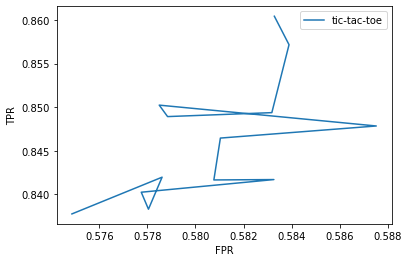

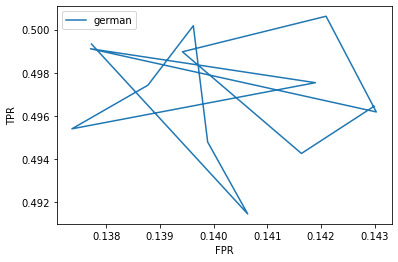

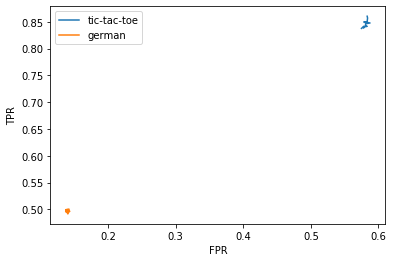

In [22]:
import matplotlib.pyplot as plt 
#FPRsTictac2 =[0.5832778775085573, 0.583887647931541, 0.5831732020277167, 0.5788404701336916, 0.5784932527035866, 0.5875137312995748, 0.5810347901609046, 0.5807638009248944, 0.5832583027938535, 0.5777463748602666, 0.5780457141293613, 0.5786120393927854, 0.5748646817480539]
#TPRsTictac2 =[0.8604436341237672, 0.8571754690590844, 0.8493756040189296, 0.8489218121909116, 0.8502377717475785, 0.8478434507086544, 0.846455160931404, 0.8416477978890965, 0.8416903075378991, 0.8402380817147537, 0.8382898110802804, 0.8419634765302578, 0.8377467905081563]
#FPRsGerman2 = [0.1429912764873082, 0.1416374049231192, 0.13942095312095312, 0.14209584150740268, 0.14303154221831807, 0.13770717774289204, 0.14189799566930078, 0.13736179455465172, 0.13877771804419398, 0.1396232912873956, 0.13989033877387105, 0.14063609430124627, 0.13772648510887664]
#TPRsGerman2 =[0.4964527127952247, 0.49426648844982185, 0.4989736405569739, 0.5006189295960226, 0.49618832514696515, 0.4991133933967267, 0.4975427965049481, 0.495406351056351, 0.49742709739330637, 0.5001801689390358, 0.4947977384366288, 0.49146707771933107, 0.4993323985854194]

plt.plot(FPRsTictac2, TPRsTictac2 , label='tic-tac-toe')
plt.xlabel('FPR') 
plt.ylabel('TPR')
plt.legend()
plt.show()

plt.plot(FPRsGerman2, TPRsGerman2, label='german')
plt.xlabel('FPR') 
plt.ylabel('TPR')
plt.legend()
plt.show()

plt.plot(FPRsTictac2, TPRsTictac2 , label='tic-tac-toe')
plt.plot(FPRsGerman2, TPRsGerman2, label='german')
plt.xlabel('FPR') 
plt.ylabel('TPR')
plt.legend()
plt.show()


### FPR, TPR variando un threshold $\alpha$

Ahora sí, para este estudio creamos un nuevo método en `Clasificador`, `clasificaROC`, y modificamos ligeramente la función de validación para crear `validaciónROC`. 

Con estas funciones, validamos un modelo capaz de clasificar datos según si la probabilidad del dato dada la clase es mayor o menor que un cierto parámetro $\alpha$.
En la siguiente celda, guardamos los FPR, TPR asociados a aplicar esta clasificación a los datos de german y de tic-tac-toe (que son los que tienen dos clases, y por tanto donde el concepto de positive/negative tiene sentido).

Damos distintos valores a $\alpha$, y graficamos los puntos (FPR, TPR) de cada caso.

In [6]:
from plantillasArquitectura import Datos as d
from plantillasArquitectura import EstrategiaParticionado as ep
from plantillasArquitectura import Clasificador as cl
import numpy as np

datasetTIC = d.Datos('./plantillasArquitectura/datos/tic-tac-toe.data')
datasetGER = d.Datos('./plantillasArquitectura/datos/german.data')

clasificador = cl.ClasificadorNaiveBayes()
TPRsTictac = []
FPRsTictac = []
TPRsGerman = []
FPRsGerman = []

for i in range(10, 1000, 10):
    estrategia = ep.ValidacionSimple(25)
    TPTic = 0
    FPTic = 0
    FNTic = 0
    TNTic = 0
    TPGer = 0
    FPGer = 0
    FNGer = 0
    TNGer = 0    
    errores, matriz = clasificador.validacionROC(estrategia,datasetTIC,clasificador, laplace = True, alpha = i/1000)    
    TPTic += matriz[0][0]
    FPTic += matriz[0][1]
    FNTic += matriz[1][0]
    TNTic += matriz[1][1]
    errores, matriz = clasificador.validacionROC(estrategia,datasetGER,clasificador, laplace = True, alpha = i/1000)    
    TPGer += matriz[0][0]
    FPGer += matriz[0][1]
    FNGer += matriz[1][0]
    TNGer += matriz[1][1]    
    TPRsTictac.append(TPTic/(TPTic+FNTic))
    FPRsTictac.append(FPTic/(FPTic+TNTic))
    TPRsGerman.append(TPGer/(TPGer+FNGer))
    FPRsGerman.append(FPGer/(FPGer+TNGer))
    
    if not i%100:
        print('Vamos por la iteracion', i)

Vamos por la iteracion 100
Vamos por la iteracion 200
Vamos por la iteracion 300
Vamos por la iteracion 400
Vamos por la iteracion 500
Vamos por la iteracion 600
Vamos por la iteracion 700
Vamos por la iteracion 800
Vamos por la iteracion 900


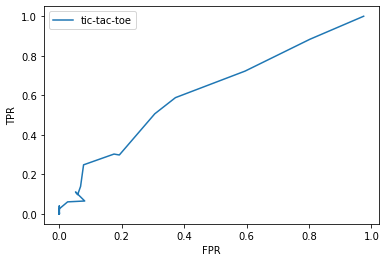

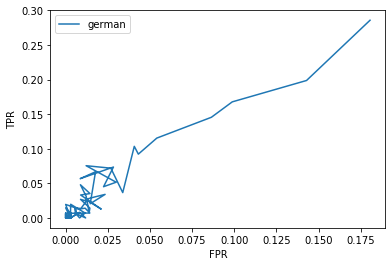

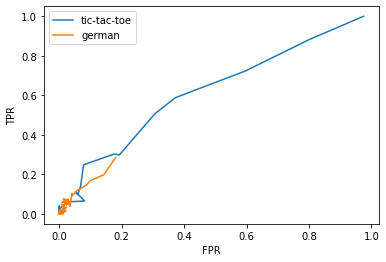

In [7]:
import matplotlib.pyplot as plt 
plt.plot(FPRsTictac, TPRsTictac , label='tic-tac-toe')
plt.xlabel('FPR') 
plt.ylabel('TPR')
plt.legend()
plt.show()

plt.plot(FPRsGerman, TPRsGerman, label='german')
plt.xlabel('FPR') 
plt.ylabel('TPR')
plt.legend()
plt.show()

plt.plot(FPRsTictac, TPRsTictac , label='tic-tac-toe')
plt.plot(FPRsGerman, TPRsGerman, label='german')
plt.xlabel('FPR') 
plt.ylabel('TPR')
plt.legend()
plt.show()


Para $\alpha$ lo suficientemente cercanos a 0, los puntos en la gráfica se acercan al (1,1), ya que con $\alpha = 0$ todos los datos son clasificados como positivos: por tanto, no hay 'Ns': tanto TN como FN van a 0, por lo que FPR = TPR = 1.

Lo contrario ocurre para $\alpha$ cercanos a 1, estos son los que corresponden a los valores cercanos a (0,0) en el plano.

Vemos que ambas curvas quedan ligeramente por encima de la diagonal, lo cual nos indica que nuestra clasificación no es terrible, pero deja mucho que desear: está bastante cerca de una clasificación estilo 'lanzar una moneda al aire' (por su cercanía a la diagonal)

La curva correspondiente a german.data se corta antes de llegar al (1,1) debido a que los valores de $\alpha$ que eran suficientemente pequeños para hacer cercanos a uno los valores de FPR, TPR, incurrían en errores numéricos para el fichero de tic-tac-toe. De cualquier modo se puede comprobar en una celda aparte que, efectivamente, para valores sufucientemente bajos de alpha los puntos (FPR,TPR) tienden a (1,1) por encima de la diagonal también para german.data